# Exclusion zones

Let's see if we can quickly create a particle simulation that has exclusion zones based on Lennard-Jones (or related) potentials. Let's set up some helpful starting points:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib import animation, rc
from IPython.display import HTML

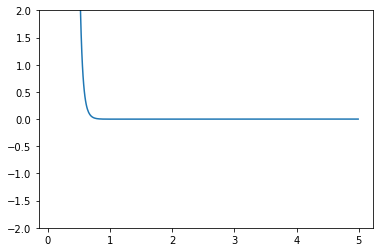

In [55]:
ljp = lambda e, rm, r: e*((rm/r)**12 - 2*(rm/r)**6)

x = np.arange(.1, 5, .01)
plt.plot(x, ljp(.001, 1, x))
plt.ylim((-2,2));

Now we can create a particle class that knows a LJP and tracks its location etc. 

In [59]:
class Part:
    def __init__(self, loc, rad=0.1):
        """Take an xy location and particle radius"""
        self.loc = np.array(loc).astype(float)
        self.rad = rad
        self.e = 0.001 #LJP well depth
        self.ts = 0.0001 #Timestep for movement
    
    def move(self, force, wrap=None):
        """Move in response to a force, 
        we're in a low Reynold's number regiem 
        so movement is proportional to force
        Wrap gives circular boundary conditions to 
        wrap around if we so desire. 
        """
        dist = np.multiply(force, self.ts)
        dist = np.clip(dist, -.1, .1)
        self.loc += dist
        if wrap is not None:
            self.loc = np.mod(self.loc, wrap)
        
    def repulse(self, dist):
        """How much force this particle exerts on another"""
        if dist>2*self.rad:
            return 0.0
        else:
            return ljp(self.e, self.rad, dist)
    
    def force_vec(self, op):
        """Force 2 particles exert on each other"""
        vec = op.loc - self.loc
        dist = np.linalg.norm(vec)
        mag = op.repulse(dist-self.rad)+self.repulse(dist-op.rad)
        f_vec = mag * vec / dist
        return f_vec
    
    def plot(self, ax, patches=None):
        """Show self on axis"""
        loc, r = self.loc, self.rad
        if patches is None:
            cp = matplotlib.patches.CirclePolygon
            pe = ax.add_patch(cp(loc, r, edgecolor='k', fill=False))
            pc = ax.add_patch(cp(loc, .2*r, facecolor='k'))
        else:
            pe, pc = patches
            pe.xy = loc
            pc.xy = loc
        return pe, pc
        
class Space:
    def __init__(self, dims):
        """Create a space with dims"""
        self.dims = dims
        self.parts = []
        self.patches = None
    
    def add_part(self, loc, rad=0.1):
        self.parts.append(Part(loc, rad))
    
    def timestep(self):
        forces = []
        for p in self.parts:
            all_particle_forces = [op.force_vec(p) for op in self.parts if op is not p]
            forces.append(np.sum(all_particle_forces,0))
        for particle, force in zip(self.parts, forces):
            particle.move(force, self.dims)
    
    def plot(self, ax, patches=None):
        if self.patches is None:
            self.patches = [p.plot(ax) for p in self.parts]
        else:
            self.patches = [p.plot(ax, patch) for p, patch in zip(self.parts, self.patches)]
        return self.patches
        

We create a random space and visualize it to make sure this is interpretable.

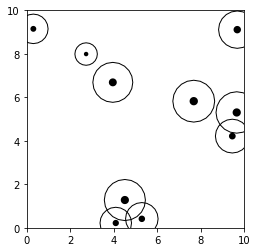

In [4]:
space = Space((10,10))
[space.add_part(np.random.rand(2)*10, .5+.5*np.random.rand()) for p in range(10)];

fig, ax = plt.subplots(1,1)
ax.set(aspect='equal', xlim=(0,10), ylim=(0,10));
space.plot(ax);

I think I get it. The rendering of this highlights an obvious flaw in the system. We aren't rendering or accounting for the parts of a particle that stick across the circular boundaries, we are only wrapping if the center of the particle crosses the boundary. Oh well, that is for version 2. 

Now let's run some timesteps and see how the particles do at repelling each other. The simplest case is to create two particles and make one run into the other. 

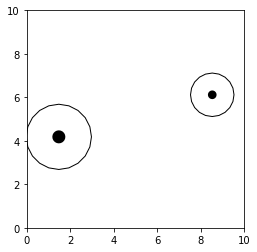

In [57]:
space = Space((10,10))
space.add_part((4,5.1),1.5)
space.add_part((6,5.2),1)

fig, ax = plt.subplots(1,1)
ax.set(aspect='equal', xlim=(0,10), ylim=(0,10));

def init():
    return space.plot(ax)

def animate(i):
    space.parts[0].loc += (.1,0)
    space.timestep()
    return space.plot(ax)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=False)

HTML(anim.to_html5_video())

That works about as well as I'd expect. Let's finish out this notebook by creating a space full of a bunch of particles, most of which just settle but one of which is driven. 

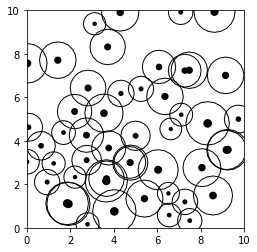

In [64]:
space = Space((10,10))
[space.add_part(np.random.rand(2)*10, .5+.5*np.random.rand()) for p in range(50)];
#[space.timestep() for i in range(1000)];

fig, ax = plt.subplots(1,1)
ax.set(aspect='equal', xlim=(0,10), ylim=(0,10));

def init():
    return space.plot(ax)

def animate(i):
    space.parts[0].loc += (.1,0)
    space.timestep()
    return space.plot(ax)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=False)

HTML(anim.to_html5_video())